# Extracting regions around the density peak (or anywhere you find)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import numpy as np
import yt #https://yt-project.org/

## Load the simulation model

In [2]:
import astro_tigress

In [3]:
# Need to set the master directory where the data is stored
# For Princeton users, this link should work
dir_master = "/tigress/munan/public_html/astro-tigress/"
# name of the simulation model
model_id = "R8_2pc" 

In [7]:
model = astro_tigress.Model(model_id,dir_master) #reading the model information
print("Snapshots and contained data sets:")
for ivtk in model.ivtks:
    print("ivtk={:d}, t={:.1f} Myr, datasets={}".format(ivtk, ivtk*model.dt_Myr, model.data_sets[ivtk]))

Snapshots and contained data sets:
ivtk=290, t=283.6 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=300, t=293.3 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=310, t=303.1 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=320, t=312.9 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=330, t=322.7 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=340, t=332.4 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=350, t=342.2 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=360, t=352.0 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=370, t=361.8 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=380, t=371.6 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']
ivtk=390, t=381.3 Myr, datasets=['MHD', 'chem', 'CO_lines', 'MHD_PI']


## Read and analyse the chemistry output

Now, we want to look into the detailed chemistry data of the simulations. This is the chemistry post-processing output from the Athena++ HDF5 output file.

First, we select a snapshot (identified by its ivtk number) and the type of dataset we want to look into ("chem" in this case). Then we need to load the data. Because the data files are large, it can take a while to load.

**Download the data if you haven't done it yet**

* [Globus](https://app.globus.org/file-manager?origin_id=dc43f461-0ca7-4203-848c-33a9fc00a464&origin_path=%2Fackh-7y71%2F)
* You can navigate the folder and only download selected snapshots.
* You will always need `histroy` and `input` files. You can run the following. 
```
    model.download(dataset=["history","input"])
    model = astro_tigress.Model(model_id,dir_master) # need to reload the class
```

In [8]:
#load the chemistry data set for the snapshot ivtk=300
model.load(370, dataset="chem")

You can print out the information of all the fields available using the code below (I commented it because the output is too long). 

In [7]:
model.chem.ytds.field_info

{('athena_pp', 'C+'): On-Disk Field ('athena_pp', 'C+'): (units: ''), ('athena_pp', 'CHx'): On-Disk Field ('athena_pp', 'CHx'): (units: ''), ('athena_pp', 'CO'): On-Disk Field ('athena_pp', 'CO'): (units: ''), ('athena_pp', 'E'): On-Disk Field ('athena_pp', 'E'): (units: ''), ('athena_pp', 'H+'): On-Disk Field ('athena_pp', 'H+'): (units: ''), ('athena_pp', 'H2'): On-Disk Field ('athena_pp', 'H2'): (units: ''), ('athena_pp', 'H2+'): On-Disk Field ('athena_pp', 'H2+'): (units: ''), ('athena_pp', 'H3+'): On-Disk Field ('athena_pp', 'H3+'): (units: ''), ('athena_pp', 'HCO+'): On-Disk Field ('athena_pp', 'HCO+'): (units: ''), ('athena_pp', 'He+'): On-Disk Field ('athena_pp', 'He+'): (units: ''), ('athena_pp', 'O+'): On-Disk Field ('athena_pp', 'O+'): (units: ''), ('athena_pp', 'OHx'): On-Disk Field ('athena_pp', 'OHx'): (units: ''), ('athena_pp', 'Si+'): On-Disk Field ('athena_pp', 'Si+'): (units: ''), ('athena_pp', 'col_avg0'): On-Disk Field ('athena_pp', 'col_avg0'): (units: ''), ('athen

# Read data using yt and store it in 3D numpy arrays 

In [9]:
# hydro quantities

Temp_chem = model.chem.grid[('gas','temperature_chem')].in_units("K").value.T # this is temperature from chemistry post-processing
Temp = model.chem.grid[('gas','temperature')].in_units("K").value.T           # this is temperature from hydro simulations
nH = model.chem.grid[('gas','nH')].in_units("cm**-3").value.T
vx = model.chem.grid[('gas','velocity_x')].in_units("km/s").value.T
vy = model.chem.grid[('gas','velocity_y')].in_units("km/s").value.T
vz = model.chem.grid[('gas','velocity_z')].in_units("km/s").value.T
xH2 = model.chem.grid["H2"].value.T
nH2 = xH2*nH

In [10]:
# coordinates
xcc = model.chem.grid[("gas","x")][:,0,0].to('pc').value
ycc = model.chem.grid[("gas","y")][0,:,0].to('pc').value
zcc = model.chem.grid[("gas","z")][0,0,:].to('pc').value

In [12]:
plt.rcParams['figure.dpi']=200

In [13]:
# |z| < 300pc region
zidx = np.abs(zcc)<300

/tmp/ipykernel_656616/1979301224.py:12: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(b1,b2,(h_xH2/h_vol).T,vmin=0,vmax=0.5)


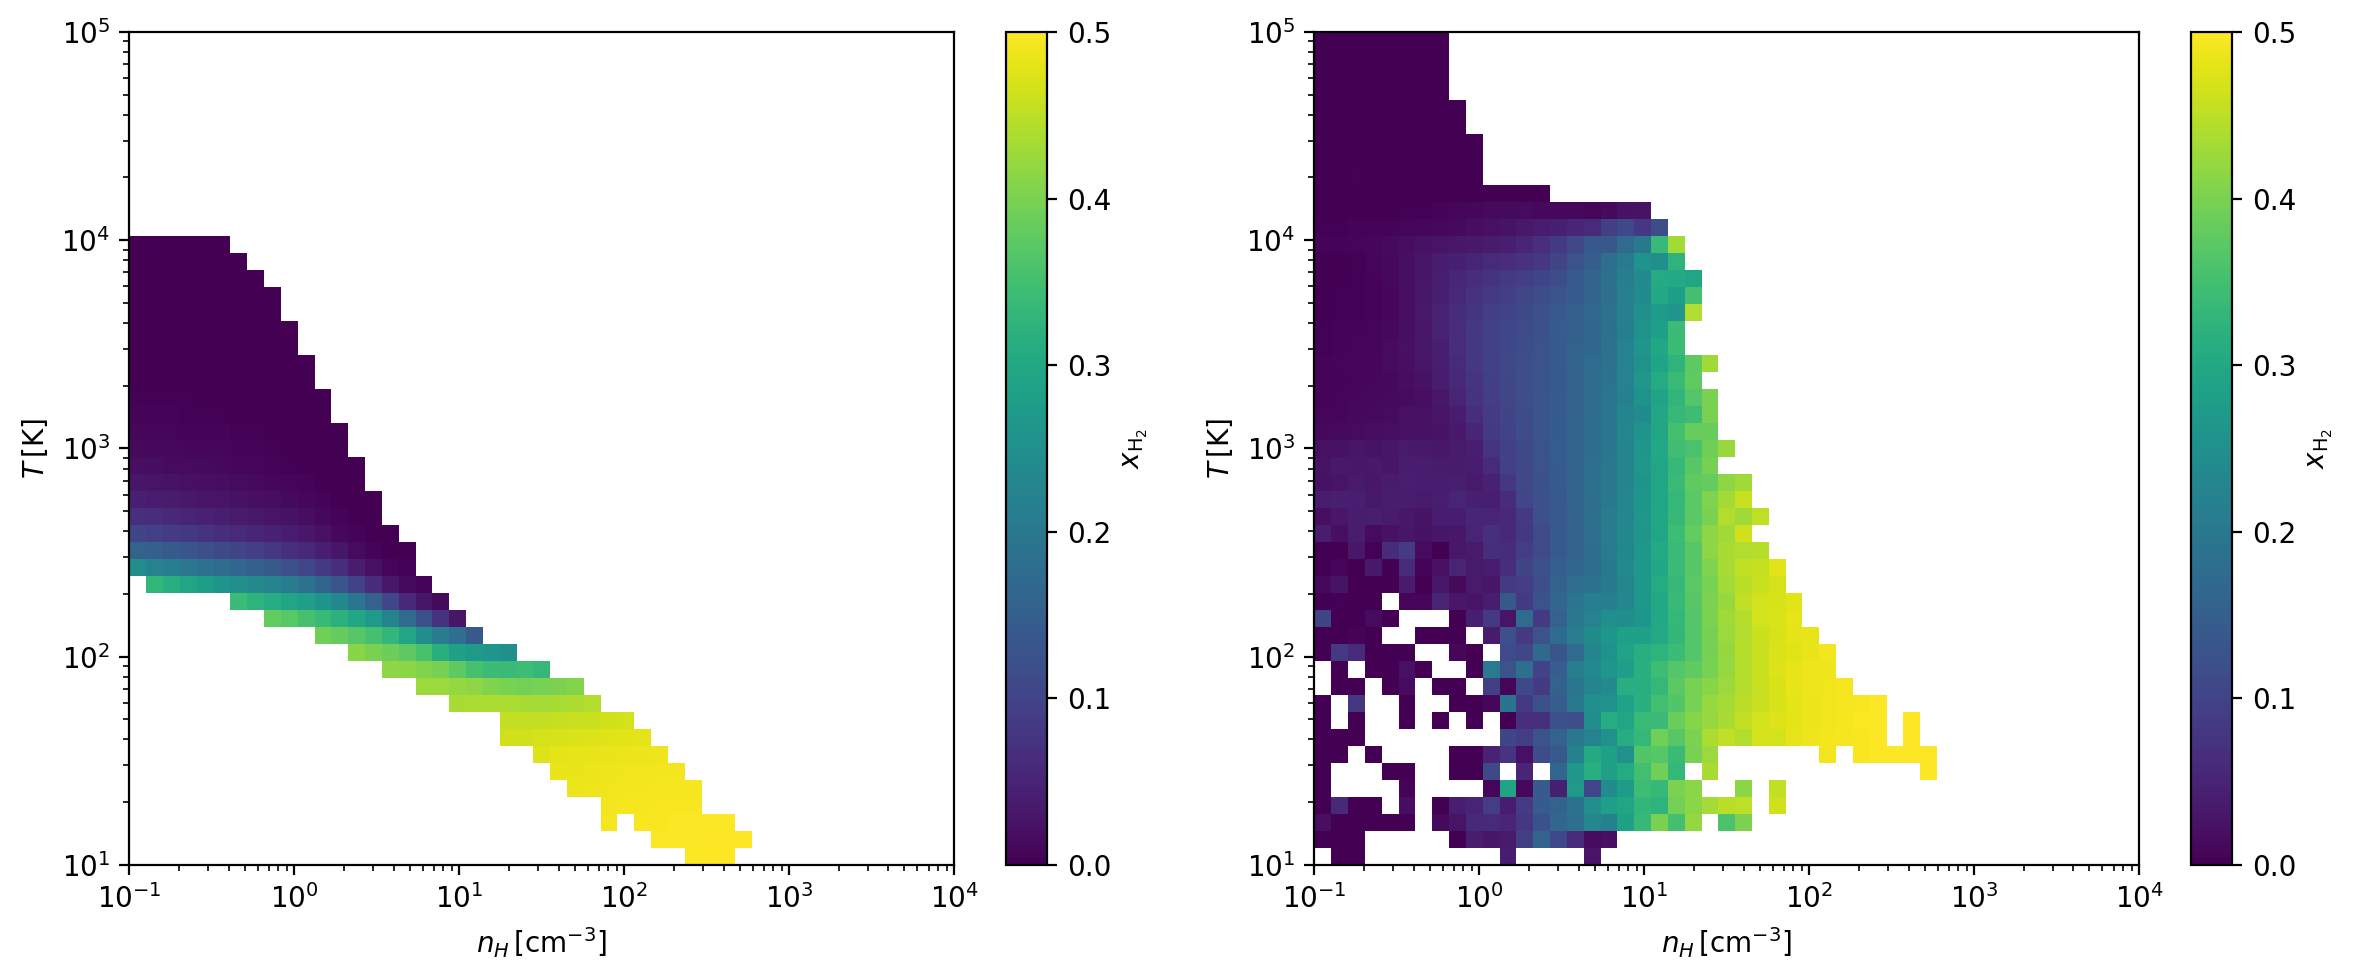

In [14]:
fig,axes = plt.subplots(1,2,figsize=(12,5))
for ax, T in zip(axes,[Temp_chem,Temp]):
    plt.sca(ax)
    pok = T*nH
    h_xH2,b1,b2=np.histogram2d((nH[zidx,:,:].flatten()),
                           (T[zidx,:,:].flatten()),
                           bins=[np.logspace(-1,4,50),np.logspace(1,5,50)],
                           weights=xH2[zidx,:,:].flatten())
    h_vol,b1,b2=np.histogram2d((nH[zidx,:,:].flatten()),
                           (T[zidx,:,:].flatten()),
                           bins=[np.logspace(-1,4,50),np.logspace(1,5,50)],)
    plt.pcolormesh(b1,b2,(h_xH2/h_vol).T,vmin=0,vmax=0.5)
    plt.colorbar(label=r'$x_{{\rm H}_2}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$n_H\,[{\rm cm^{-3}}]$')
    plt.ylabel(r'$T\,[{\rm K}]$')
plt.tight_layout()

/tmp/ipykernel_656616/2364311965.py:2: RuntimeWarning: invalid value encountered in divide
  plt.step(b1[:-1],(h_xH2.sum(axis=1)/h_vol.sum(axis=1)))


Text(0.5, 0, '$n_H\\,[{\\rm cm^{-3}}]$')

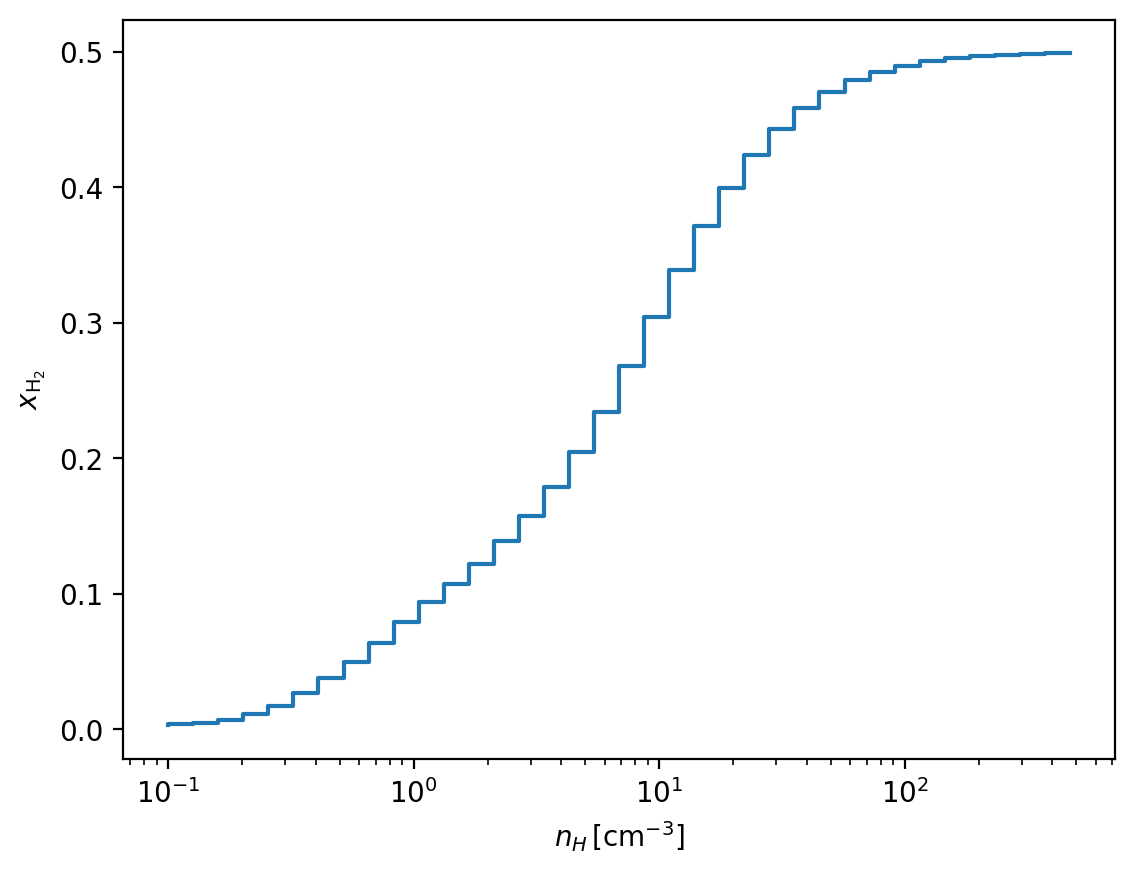

In [15]:
# mean H2 fraction as a function of density
plt.step(b1[:-1],(h_xH2.sum(axis=1)/h_vol.sum(axis=1)))
plt.xscale('log')
plt.ylabel(r'$x_{{\rm H}_2}$')
plt.xlabel(r'$n_H\,[{\rm cm^{-3}}]$')

# Quick views of H2 column density 

In [16]:
import astropy.constants as ac

In [17]:
dx = (xcc[1]-xcc[0])*ac.pc.cgs.value

In [18]:
NH2_y=nH2.sum(axis=1)*dx
NH2_x=nH2.sum(axis=2)*dx
NH2_z=nH2.sum(axis=0)*dx

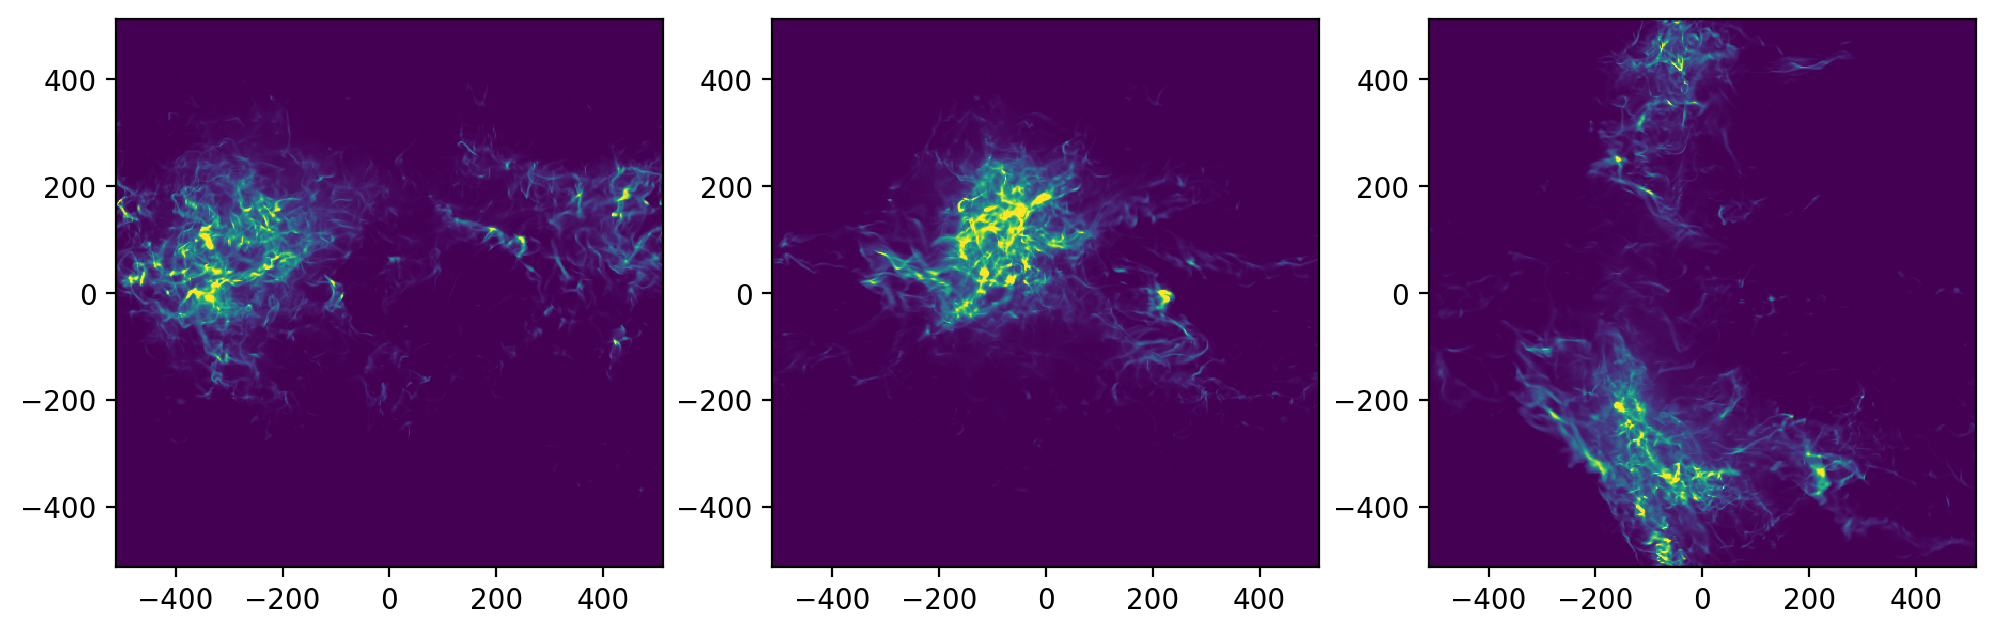

In [19]:
fig,axes = plt.subplots(1,3,figsize=(12,5))
for ax, NH2 in zip(axes,[NH2_x,NH2_y,NH2_z]):
    plt.sca(ax)
    plt.pcolormesh(xcc,zcc,NH2,vmax=2.e21)
    ax.set_aspect('equal')

# Select sub region to extract: here I chose region surrounding the density peak

In [20]:
Nz,Ny,Nx=nH2.shape
k0,j0,i0=np.unravel_index(nH2.argmax(),nH2.shape)
di = 25
dj = 25
dk = 25
il = max(i0-di,0)
jl = max(j0-dj,0)
kl = max(k0-dk,0)
iu = min(i0+di,Nx)
ju = min(j0+dj,Ny)
ku = min(k0+dk,Nz)

## Let's save subregion using a dictionary 

In [21]:
subcube = dict()

In [22]:
for label,data in zip(['nH','nH2','vx','vy','vz','Temp'],[nH,nH2,vx,vy,vz,Temp]):
    subcube[label]=data[kl:ku,jl:ju,il:iu]

subcube['x']=xcc[il:iu]
subcube['y']=ycc[jl:ju]
subcube['z']=zcc[kl:ku]

In [23]:
# caculate velocity of the density peak
vpeak=[vx[k0,j0,i0],vy[k0,j0,i0],vz[k0,j0,i0]]
# or caculate mass weighted velocity within the subregion
vpeak2 = [(subcube['nH2']*subcube['vx']).sum()/subcube['nH2'].sum(),
          (subcube['nH2']*subcube['vy']).sum()/subcube['nH2'].sum(),
          (subcube['nH2']*subcube['vz']).sum()/subcube['nH2'].sum()]


In [24]:
print(vpeak,vpeak2)

[15.891777992248533, -0.9461061358451842, -5.707179069519042] [5.244681984749008, -1.7722242463701512, -3.4380609046386486]


In [25]:
# define perturbed velocity with respect to the desnity peak
for v,v0 in zip(['vx','vy','vz'],vpeak):
    subcube['d{}'.format(v)] = subcube[v]-v0

## Now, save data into the glue-readable fits file 

In [29]:
def add_header_for_glue(hdu,hdr,axis='xyz'):
    for i,ax in enumerate(axis):
        hdu.header['CDELT{}'.format(i+1)]=hdr['d{}'.format(ax)]
        hdu.header['CTYPE{}'.format(i+1)]=ax
        hdu.header['CUNIT{}'.format(i+1)]=hdr.comments['d{}'.format(ax)]
        hdu.header['CRVAL{}'.format(i+1)]=hdr['{}min'.format(ax)]
        hdu.header['CRPIX{}'.format(i+1)]=hdr['{}max'.format(ax)]+hdr['{}min'.format(ax)]
    return

In [30]:
from astropy.io import fits

In [31]:
hdul = fits.HDUList()
hdr = fits.Header()
tMyr=model.chem.ytds.current_time.to('Myr').value
hdr['time']=float(tMyr)
hdr['xmin']=(subcube['x'][0],'pc')
hdr['xmax']=(subcube['x'][1],'pc')
hdr['ymin']=(subcube['y'][0],'pc')
hdr['ymax']=(subcube['y'][1],'pc')
hdr['zmin']=(subcube['z'][0],'pc')
hdr['zmax']=(subcube['z'][1],'pc')
hdr['dx']=(dx,'pc')
hdr['dy']=(dx,'pc')
hdr['dz']=(dx,'pc')
hdu = fits.PrimaryHDU(header=hdr)

In [32]:
hdul.append(hdu)
for label in ['nH','nH2','vx','vy','vz','dvx','dvy','dvz','Temp']:
    hdul.append(fits.ImageHDU(name=label,data=subcube[label]))    

In [33]:
hdr=hdu.header
for hdu in hdul:
    add_header_for_glue(hdu,hdr,axis='xyz')

In [34]:
fitsname='subcube.fits'

In [35]:
hdul.writeto(fitsname,overwrite=True)

## quick visualization 

In [36]:
x,y,z = np.meshgrid(subcube['x'],subcube['y'],subcube['z'],indexing='ij')
u,v,w = subcube['dvx'],subcube['dvy'],subcube['dvz']

In [40]:
idx = subcube['nH2']>1

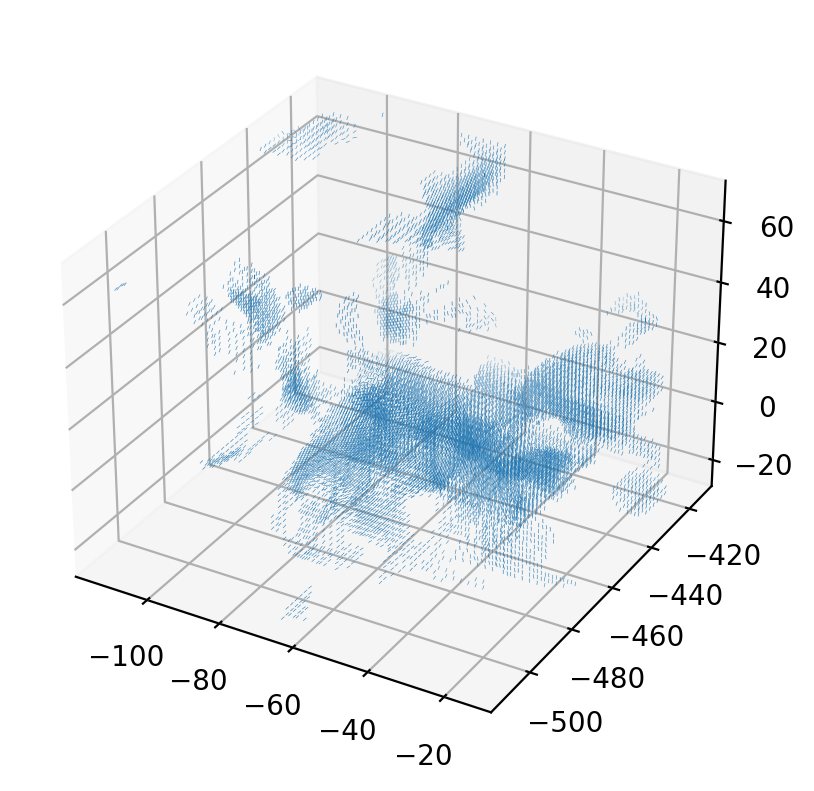

In [41]:
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(x[idx], y[idx], z[idx], u[idx], v[idx], w[idx], length=0.1, normalize=True)

## save the subregion into NetCDF file using xarray (paraview readable) 

In [42]:
import xarray as xr

In [43]:
dset = xr.Dataset()
for label in ['nH','nH2','dvx','dvy','dvz','vx','vy','vz','Temp']:
    da = xr.DataArray(subcube[label],coords=[subcube['z'],subcube['y'],subcube['x']],dims=['z','y','x'])
    dset[label]=da

In [44]:
dset.to_netcdf('subcube.nc')

In [45]:
dset.close()